FRP

In [5]:
# Turn point dataset into gridded dataset, where its horizontal resolution is 0.75º*0.75º

import pandas as pd
import numpy as np
import xarray as xr
import os

# === INPUT CSV FILE ===
csv_path = r"E:\IPMA\FRP\FRP_2000_2024.csv"

# === EXTRACT DIRECTORY AND CREATE OUTPUT FILENAME ===
base_dir = os.path.dirname(csv_path)
output_filename = "FRP_2000_2024.nc"
output_path = os.path.join(base_dir, output_filename)

# === GRID PARAMETERS ===
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34, 66
lon_min, lon_max = -12, 36

lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1]
lon_centers = lon_bins[:-1]

# === LOAD AND PREPARE DATA ===
print("Loading and filtering data...")
df = pd.read_csv(csv_path)
df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Ensure date is datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Assign grid cell
print("Assigning points to grid cells...")
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=lat_centers)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=lon_centers)
df.dropna(subset=['lat_bin', 'lon_bin'], inplace=True)

# Convert bins to float
df['lat_bin'] = df['lat_bin'].astype(float)
df['lon_bin'] = df['lon_bin'].astype(float)

# === AGGREGATE STATS ===
print("Aggregating FRP statistics...")
grouped = df.groupby(['acq_date', 'lat_bin', 'lon_bin'])

frp_stats = grouped['frp'].agg(
    FRP_sum='sum',
    FRP_mean='mean',
    FRP_median='median',
    FRP_max='max',
    FRP_min='min',
    FRP_std='std',
    count='count'
).reset_index()

# === CREATE FULL 3D ARRAYS ===
print("Creating 3D arrays...")

all_dates = pd.date_range(df['acq_date'].min(), df['acq_date'].max(), freq='D')
shape = (len(all_dates), len(lat_centers), len(lon_centers))

# Initialize arrays with NaNs
arrays = {
    'FRP_sum': np.full(shape, np.nan),
    'FRP_mean': np.full(shape, np.nan),
    'FRP_median': np.full(shape, np.nan),
    'FRP_max': np.full(shape, np.nan),
    'FRP_min': np.full(shape, np.nan),
    'FRP_std': np.full(shape, np.nan),
    'count': np.full(shape, np.nan),
}

lat_to_idx = {lat: i for i, lat in enumerate(lat_centers)}
lon_to_idx = {lon: i for i, lon in enumerate(lon_centers)}
date_to_idx = {date: i for i, date in enumerate(all_dates)}

# Fill arrays
for _, row in frp_stats.iterrows():
    d, lat, lon = row['acq_date'], row['lat_bin'], row['lon_bin']
    i, j, k = date_to_idx[d], lat_to_idx[lat], lon_to_idx[lon]
    for key in arrays:
        arrays[key][i, j, k] = row[key]

# === CREATE xarray.Dataset ===
print("Building xarray dataset...")
ds = xr.Dataset(
    {key: (["time", "latitude", "longitude"], arrays[key]) for key in arrays},
    coords={
        "time": all_dates,
        "latitude": lat_centers,
        "longitude": lon_centers,
    },
    attrs={
        "title": "Daily Gridded FRP Statistics (0.75° × 0.75°)",
        "source_file": os.path.basename(csv_path),
        "grid_resolution": "0.75 degrees",
        "description": "Includes daily FRP sum, mean, median, max, min, std, and detection count per grid cell"
    }
)

# === SAVE TO NETCDF ===
print(f"Saving to NetCDF: {output_path}")
ds.to_netcdf(output_path)
print("Done.")

Loading and filtering data...
Assigning points to grid cells...
Aggregating FRP statistics...
Creating 3D arrays...
Building xarray dataset...
Saving to NetCDF: E:\IPMA\FRP\FRP_2000_2024.nc
Done.


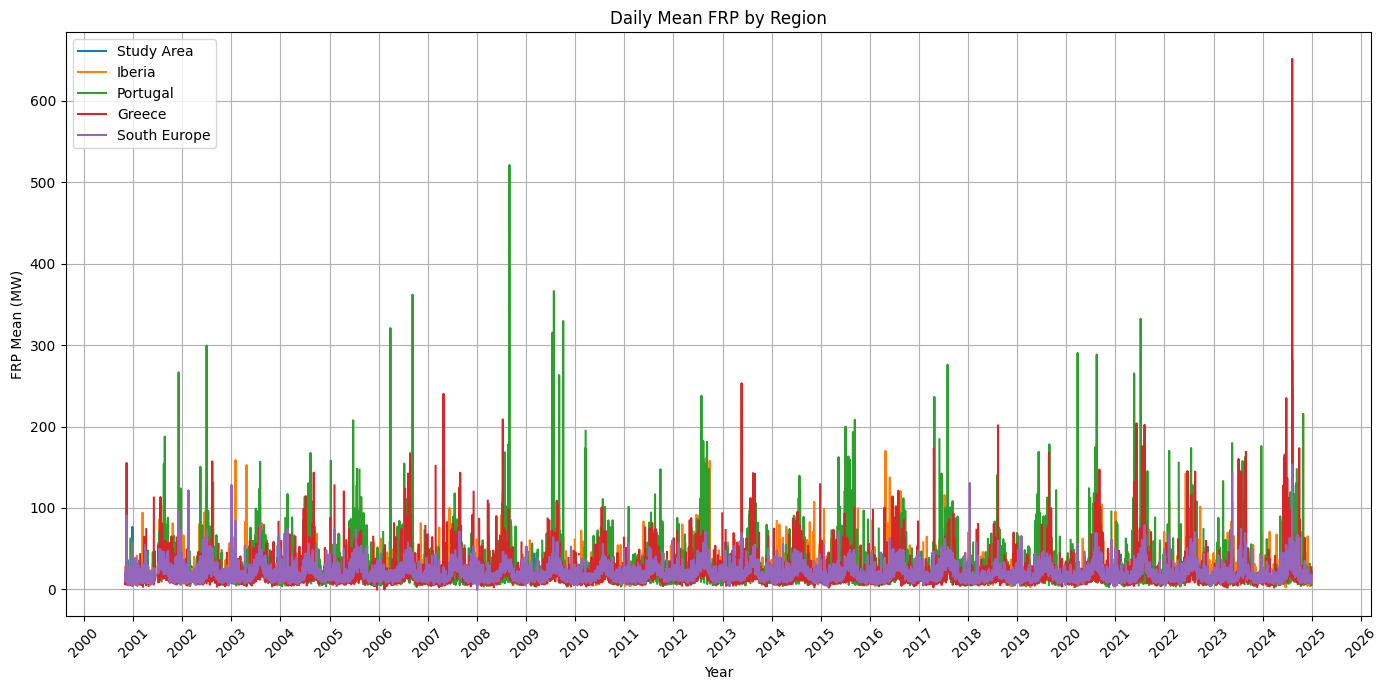

In [6]:
#Time series study area, iberia, greece, portugal, south europe with daily averages

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Load the NetCDF file
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# Define regions: (lat_min, lat_max, lon_min, lon_max)
regions = {
    "Study Area": (34, 66, -12, 36),
    "Iberia": (35, 45, -10, 5),
    "Portugal": (36, 43, -10, -6),
    "Greece": (34, 42, 19, 29),
    "South Europe": (34, 45, -10, 29),
}

# Access the daily mean FRP variable
frp_mean = ds["FRP_mean"]

# Dictionary to store time series for each region
region_series = {}

for name, (lat_min, lat_max, lon_min, lon_max) in regions.items():
    # Subset the region
    subset = frp_mean.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Calculate daily regional average (mean over lat/lon)
    daily_mean = subset.mean(dim=["latitude", "longitude"], skipna=True)
    
    # Convert to pandas Series
    region_series[name] = pd.Series(daily_mean.values, index=pd.to_datetime(daily_mean["time"].values))

# Plotting
plt.figure(figsize=(14, 7))

for name, series in region_series.items():
    plt.plot(series.index, series, label=name)

plt.title("Daily Mean FRP by Region")
plt.xlabel("Year")
plt.ylabel("FRP Mean (MW)")
plt.grid(True)
plt.legend()

# Format x-axis to show every year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#Variability boxplot

In [ ]:
#Excedencias tabela total

In [ ]:
#Fire days

In [ ]:
#No Fire days

In [ ]:
#FRP para grelha